In [21]:
# %%
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from brisque import BRISQUE

# Para visualização inline no Jupyter
%matplotlib inline

# Definir o caminho onde estão as imagens
dataset_path = '../../data/categorized_images/all'


In [22]:
# %%
def calculate_sharpness_laplacian(image_bgr):
    """
    Sharpness via variância do Laplaciano em escala de cinza.
    """
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return laplacian.var()


def calculate_snr(image_bgr):
    """
    Cálculo simples de SNR = média / desvio padrão do canal cinza.
    """
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    mean_val = np.mean(gray)
    std_val = np.std(gray)
    if std_val == 0:
        # Se não houver variação, então o SNR é infinito (ou zero, dependendo do caso)
        return float('inf') if mean_val != 0 else 0
    return mean_val / std_val


def calculate_contrast_brightness(image_bgr):
    """
    Retorna (contraste, brilho) em escala de cinza.
    - Contraste = diferença entre valor máx e mín (faixa)
    - Brilho = média de intensidade
    """
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    contrast = gray.max() - gray.min()
    brightness = gray.mean()
    return contrast, brightness


def calculate_image_size(image_bgr):
    """
    Tamanho da imagem (width, height).
    """
    height, width = image_bgr.shape[:2]
    return (width, height)


def calculate_brisque_score(image_bgr):
    """
    Utiliza a biblioteca 'brisque' do PyPI:
    https://pypi.org/project/brisque/
    Precisamos converter a imagem BGR (OpenCV) para um array no estilo PIL.
    """
    # Converter BGR -> RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    # A biblioteca brisque aceita um array numpy que represente uma imagem
    # no formato RGB (exatamente como seria np.asarray(Image)).
    obj = BRISQUE(url=False)
    score = obj.score(img=image_rgb)
    return score

In [23]:
# %%
from tqdm import tqdm

image_files = [
    f for f in os.listdir(dataset_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
]

results = []

# Utilizando tqdm para exibir o progresso
for img_name in tqdm(image_files, desc="Calculando métricas", ncols=80):
    img_path = os.path.join(dataset_path, img_name)
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        print(f"Não foi possível abrir a imagem: {img_name}")
        continue

    # Sharpness
    sharpness = calculate_sharpness_laplacian(image_bgr)

    # SNR
    snr_value = calculate_snr(image_bgr)

    # Contraste e brilho
    contrast, brightness = calculate_contrast_brightness(image_bgr)

    # Tamanho
    width, height = calculate_image_size(image_bgr)

    # BRISQUE
    brisque_score = calculate_brisque_score(image_bgr)

    results.append({
        'filename': img_name,
        'sharpness': sharpness,
        'snr': snr_value,
        'contrast': contrast,
        'brightness': brightness,
        'width': width,
        'height': height,
        'brisque': brisque_score
    })

df = pd.DataFrame(results)
df.head()

Calculando métricas:   0%|                             | 0/3406 [00:00<?, ?it/s]

Calculando métricas:   2%|▎                   | 57/3406 [00:02<02:06, 26.38it/s]/mnt/c/Users/Ricardo/Documents/Development/tcc-1/venv/lib/python3.12/site-packages/brisque/brisque.py:123: RuntimeWarning: invalid value encountered in divide
  return squares_sum / ((filtered_values.shape))
Calculando métricas: 100%|██████████████████| 3406/3406 [02:39<00:00, 21.35it/s]


,filename,sharpness,snr,contrast,brightness,width,height,brisque
0,00c571edd_jpg.rf.4184a179630e91b170f3d085f3560...,7128.542628,1.797335,249,64.451880,76,35,12.183082
1,026bb1723_jpg.rf.b6669cecd3e40790682e180b78076...,4721.131903,0.886032,253,36.375711,69,79,11.253974
2,056949650_jpg.rf.cbb1f0013e0b0477ab115b1ca5032...,3969.846246,1.109746,253,54.198399,131,103,-5.778199
3,05ef7a103_jpg.rf.456682ee7c9a74f259775eb9f2d17...,1372.469375,1.491622,130,57.766667,10,12,155.845000
4,0692c75b0_jpg.rf.6f54b40daa84a400270eb7a9cc4fb...,6562.439958,1.862933,224,146.950226,17,13,155.845000


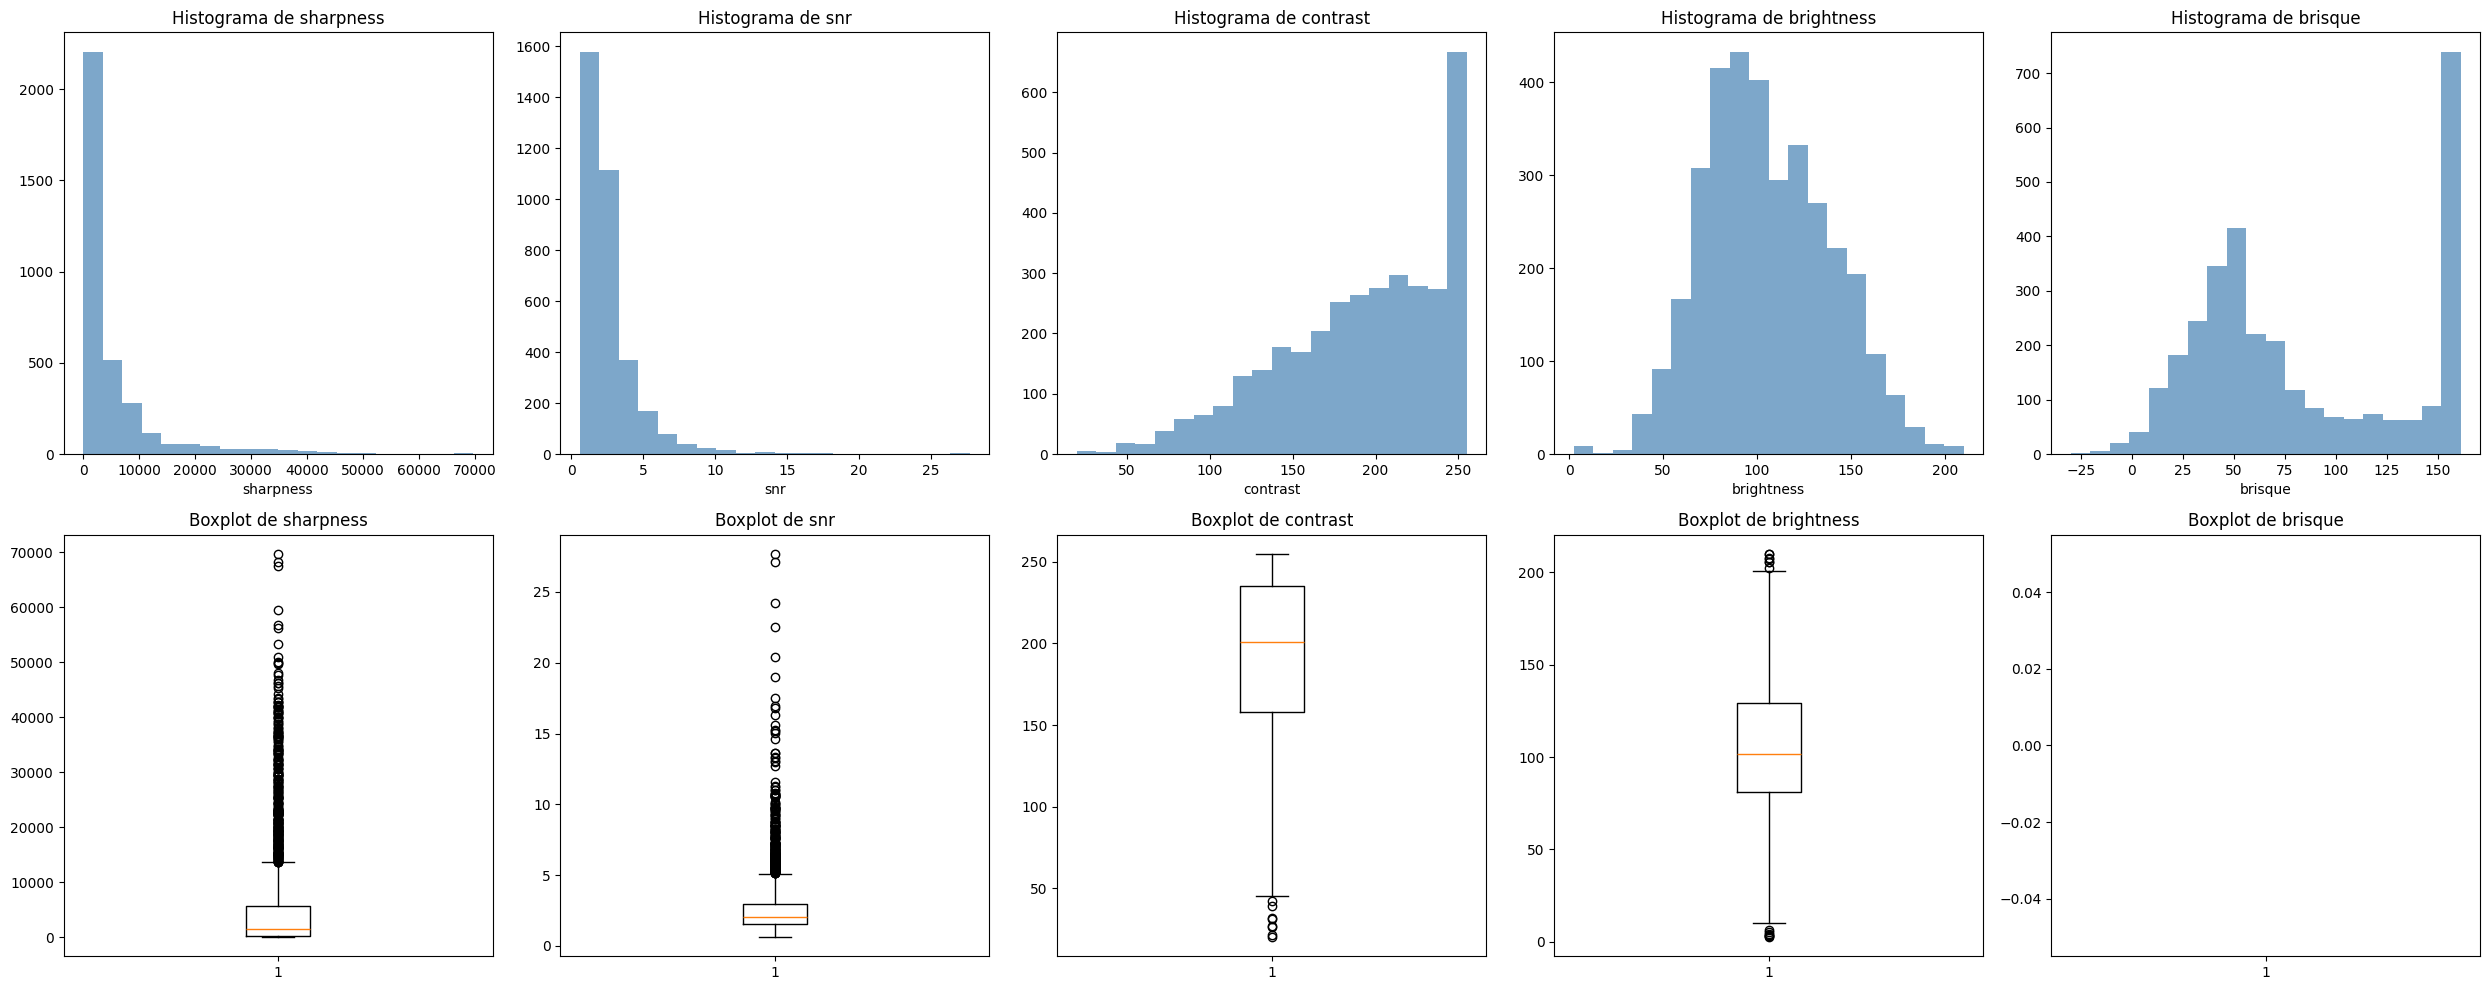

In [24]:
# %%
metrics = ['sharpness', 'snr', 'contrast', 'brightness', 'brisque']

fig, axes = plt.subplots(nrows=2, ncols=len(
    metrics), figsize=(5 * len(metrics), 10))

for i, metric in enumerate(metrics):
    ax_hist = axes[0, i]
    ax_box = axes[1, i]

    # Histograma
    ax_hist.hist(df[metric], bins=20, color='steelblue', alpha=0.7)
    ax_hist.set_title(f'Histograma de {metric}')
    ax_hist.set_xlabel(metric)

    # Boxplot
    ax_box.boxplot(df[metric], vert=True)
    ax_box.set_title(f'Boxplot de {metric}')

plt.tight_layout()
plt.show()

In [25]:
# %%
def show_top_bottom_images(df, metric, top_n=5):
    """
    Retorna dois dataframes:
      - bottom_images: as piores (valores menores de metric)
      - top_images: as melhores (valores maiores de metric)
    """
    sorted_df = df.sort_values(by=metric)
    bottom_images = sorted_df.head(top_n)
    top_images = sorted_df.tail(top_n)
    # Inverter a ordem para exibirmos do maior para o menor no top_images
    top_images = top_images.iloc[::-1]
    return bottom_images, top_images


def plot_images_side_by_side(df_images, metric, title='', max_images=5):
    """
    Plota as imagens em uma única linha, cada subplot mostrando o valor do metric.
    """
    fig, axes = plt.subplots(1, max_images, figsize=(5*max_images, 5))
    fig.suptitle(title, fontsize=14)

    for ax, (_, row) in zip(axes, df_images.iterrows()):
        img_path = os.path.join(dataset_path, row['filename'])
        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            ax.axis('off')
            continue

        # Converter para RGB para exibir corretamente no Matplotlib
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(image_rgb)
        # ax.set_title(f"{row['filename']}\n{metric}: {row[metric]:.2f}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

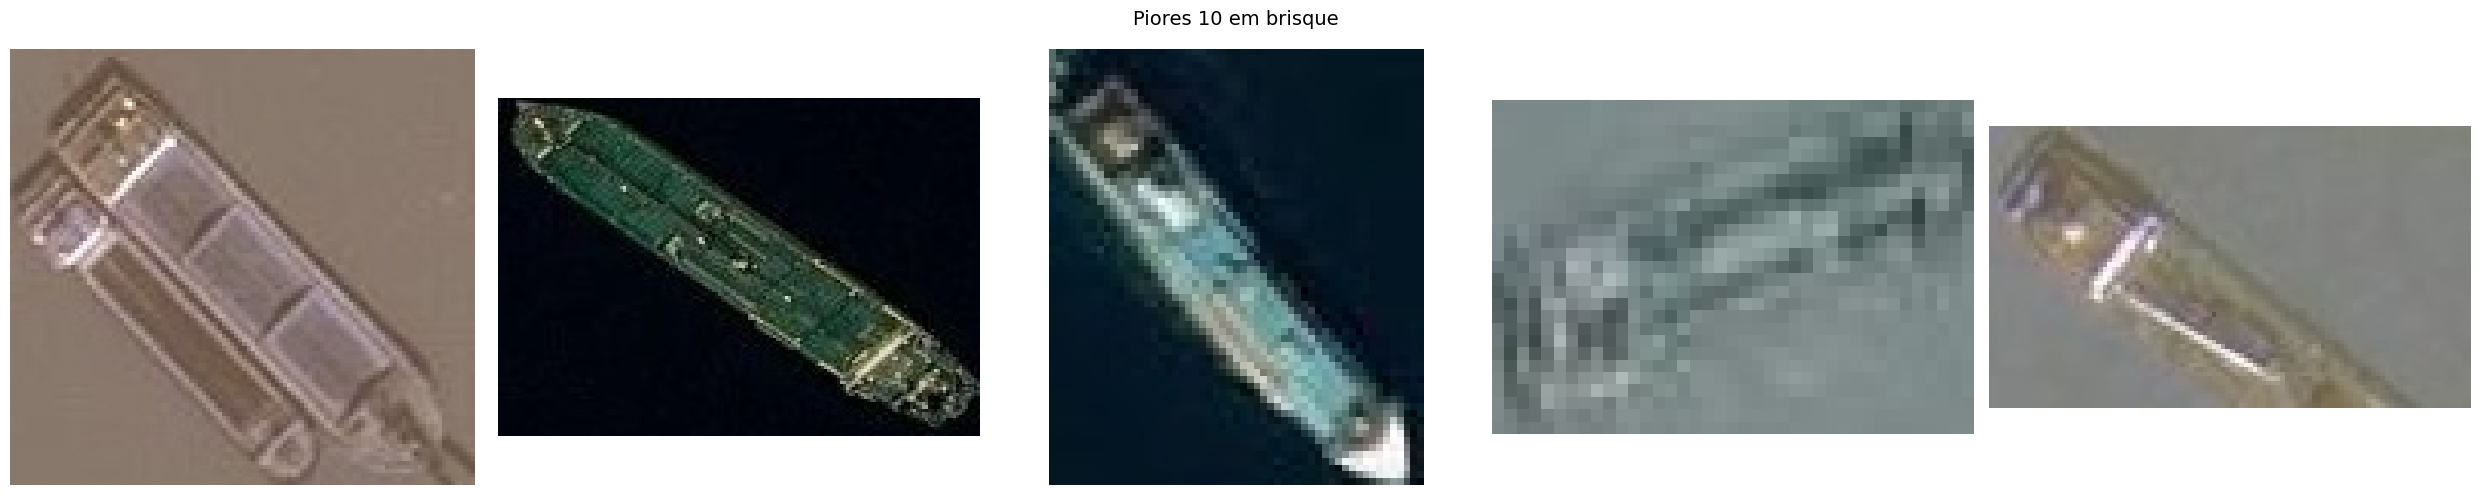

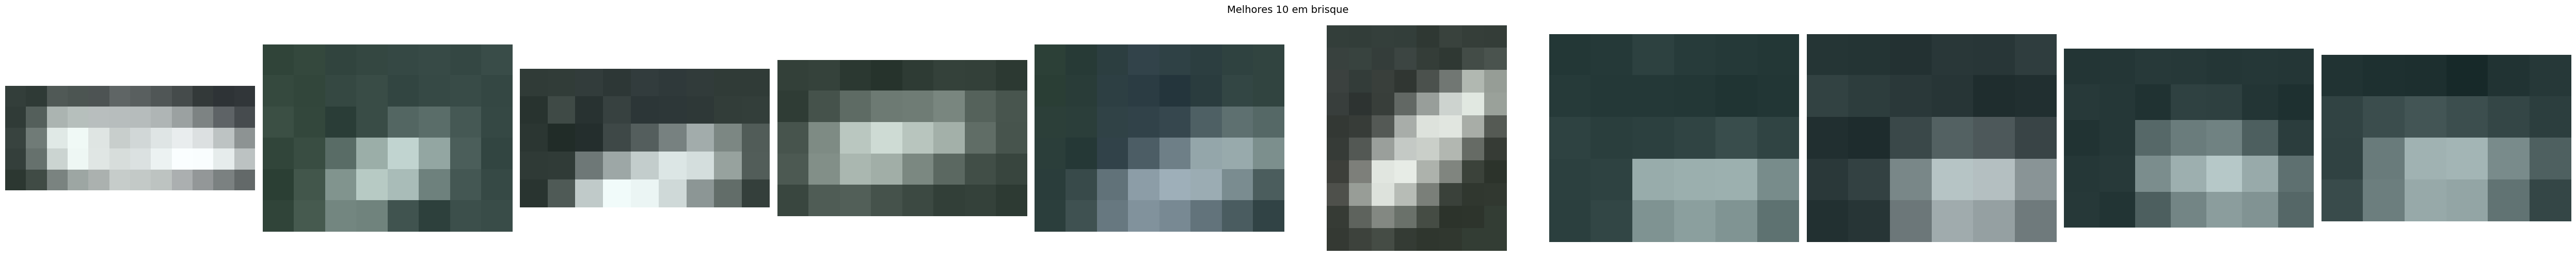

In [33]:
metrics = ['brisque']
N = 10
for metric in metrics:
    bottom_imgs, top_imgs = show_top_bottom_images(df, metric, top_n=N)
    plot_images_side_by_side(
        bottom_imgs, metric, title=f"Piores {N} em {metric}")
    plot_images_side_by_side(top_imgs, metric, title=f"Melhores {N} em {metric}", max_images=N)

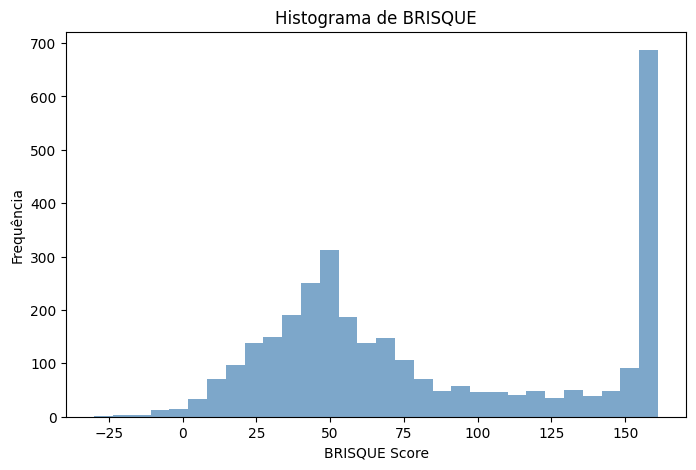

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df['brisque'], bins=30, color='steelblue', alpha=0.7)
plt.title('Histograma de BRISQUE')
plt.xlabel('BRISQUE Score')
plt.ylabel('Frequência')
plt.show()

In [28]:
print("Estatísticas de BRISQUE:")
print(df['brisque'].describe())

Estatísticas de BRISQUE:
count    3164.000000
mean       82.475672
std        51.035486
min       -29.926654
25%        42.637837
50%        64.680812
75%       146.476942
max       161.100006
Name: brisque, dtype: float64


Contagem de itens por categoria (Quantis):
cat_quantile
Media    1582
Ruim     1033
Boa       791
Name: count, dtype: int64

Contagem de itens por categoria (Thresholds):
cat_threshold
Ruim     1355
Media    1342
Boa       709
Name: count, dtype: int64


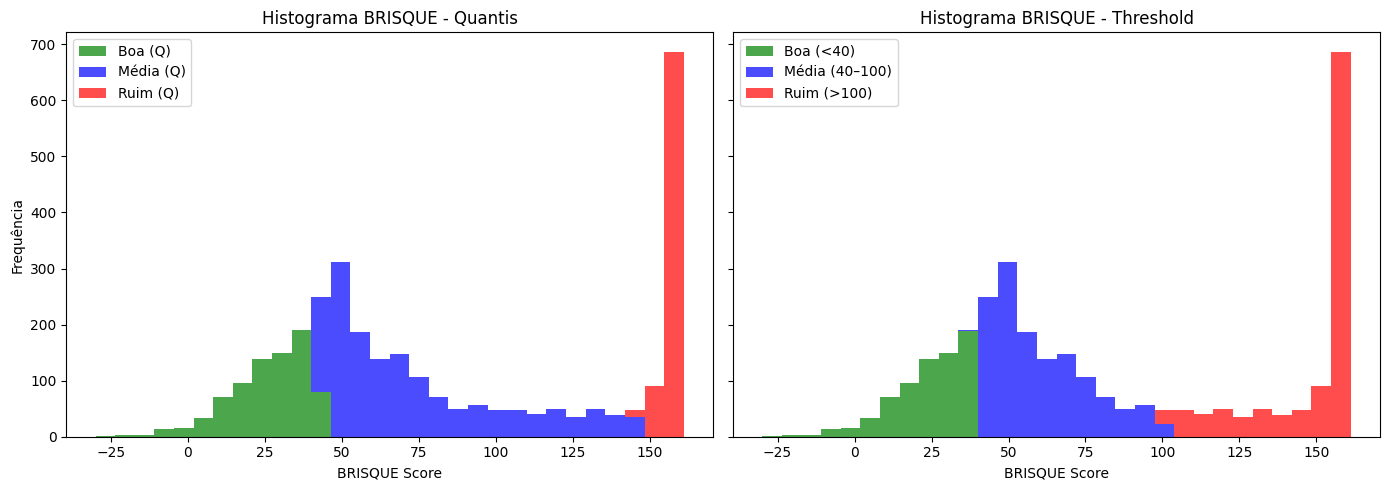

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que df['brisque'] contenha os valores de BRISQUE

# 1. Calcular Q1 e Q3
q1 = df['brisque'].quantile(0.25)  # ~42.637837
q3 = df['brisque'].quantile(0.75)  # ~146.476942

# 2. Estratégia de quantis
def categorize_by_quantile(score, q1, q3):
    if score < q1:
        return 'Boa'
    elif score < q3:
        return 'Media'
    else:
        return 'Ruim'

# 3. Estratégia de thresholds fixos
def categorize_by_threshold(score):
    if score < 40:
        return 'Boa'
    elif score <= 100:
        return 'Media'
    else:
        return 'Ruim'

# 4. Criar colunas com as categorias
df['cat_quantile'] = df['brisque'].apply(lambda x: categorize_by_quantile(x, q1, q3))
df['cat_threshold'] = df['brisque'].apply(categorize_by_threshold)

# 5. Contar os itens por categoria
quantile_counts = df['cat_quantile'].value_counts()
threshold_counts = df['cat_threshold'].value_counts()

print("Contagem de itens por categoria (Quantis):")
print(quantile_counts)

print("\nContagem de itens por categoria (Thresholds):")
print(threshold_counts)

# 6. Plotar dois histogramas lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Histograma por quantil ---
ax1 = axes[0]
data_boas_q = df.loc[df['cat_quantile'] == 'Boa', 'brisque']
data_medias_q = df.loc[df['cat_quantile'] == 'Media', 'brisque']
data_ruins_q = df.loc[df['cat_quantile'] == 'Ruim', 'brisque']

ax1.hist([data_boas_q, data_medias_q, data_ruins_q],
         bins=30, stacked=True,
         color=['green', 'blue', 'red'], alpha=0.7,
         label=['Boa (Q)', 'Média (Q)', 'Ruim (Q)'])
ax1.set_title('Histograma BRISQUE - Quantis')
ax1.set_xlabel('BRISQUE Score')
ax1.set_ylabel('Frequência')
ax1.legend()

# --- Histograma por threshold fixo ---
ax2 = axes[1]
data_boas_t = df.loc[df['cat_threshold'] == 'Boa', 'brisque']
data_medias_t = df.loc[df['cat_threshold'] == 'Media', 'brisque']
data_ruins_t = df.loc[df['cat_threshold'] == 'Ruim', 'brisque']

ax2.hist([data_boas_t, data_medias_t, data_ruins_t],
         bins=30, stacked=True,
         color=['green', 'blue', 'red'], alpha=0.7,
         label=['Boa (<40)', 'Média (40–100)', 'Ruim (>100)'])
ax2.set_title('Histograma BRISQUE - Threshold')
ax2.set_xlabel('BRISQUE Score')
ax2.legend()

plt.tight_layout()
plt.show()

Contagem de itens por categoria:
categoria
Boa     2373
Ruim    1033
Name: count, dtype: int64


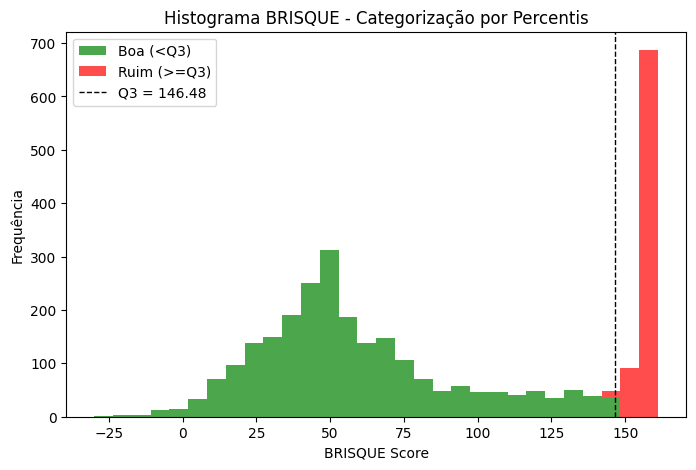

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Supondo que df['brisque'] contenha os valores de BRISQUE

# 1. Calcular o percentil 75 (Q3)
q3 = df['brisque'].quantile(0.75)  # ~146.476942

# 2. Estratégia de quantis (duas classes: Boa e Ruim)
def categorize_by_quantile(score, q3):
    return 'Boa' if score < q3 else 'Ruim'

# 3. Criar coluna com a nova categorização
df['categoria'] = df['brisque'].apply(lambda x: categorize_by_quantile(x, q3))

# 4. Contar os itens por categoria
category_counts = df['categoria'].value_counts()
print("Contagem de itens por categoria:")
print(category_counts)

# 5. Plotar o histograma
plt.figure(figsize=(8, 5))

data_boas = df.loc[df['categoria'] == 'Boa', 'brisque']
data_ruins = df.loc[df['categoria'] == 'Ruim', 'brisque']

plt.hist([data_boas, data_ruins], bins=30, stacked=True, color=['green', 'red'], alpha=0.7, 
         label=['Boa (<Q3)', 'Ruim (>=Q3)'])
plt.axvline(q3, color='black', linestyle='dashed', linewidth=1, label=f'Q3 = {q3:.2f}')
plt.title('Histograma BRISQUE - Categorização por Percentis')
plt.xlabel('BRISQUE Score')
plt.ylabel('Frequência')
plt.legend()
plt.show()
